## Capstone Project  - Classifying Higher Scoring Football Matches 

**Philip Burroughs:**
26/03/2019

In [40]:
# Install all libraries needed here:
import pandas as pd 
import numpy as np
import array as arr
import csv
import time 
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer , fbeta_score 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score, precision_score
from sklearn.base import BaseEstimator

# Machine learning algorithms
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 


# Custom Built Functions
import poisson_dist as p # From a seperate .py file
import poisson_score as ps # From a seperate .py file
import Visuals as vs  # From a seperate .py file 
import train_test as tt # From a seperate .py filemport
import train_graph as tg # From a seperate .py file


**Data Exploration:**

In [41]:
# Import the dataset 
football_data = pd.read_csv("football_data.csv")

# The name was too long - Made my later graphs take up too much room
football_data['div_name'] = football_data['div_name'].mask(football_data.div_name == 'English Vanarama National League'
                                                           ,'English National League')
football_data.head()

div_name div  unique_season  row_number     hometeam  \
0  Belgium Jupiler League  B1             13           1     Kortrijk   
1  Belgium Jupiler League  B1             13           2     Mechelen   
2  Belgium Jupiler League  B1             13           3     Germinal   
3  Belgium Jupiler League  B1             13           4  Club Brugge   
4  Belgium Jupiler League  B1             13           5       Bergen   

              awayteam  hometeam_instance  awayteam_instance  hthg  htag  \
0           Anderlecht                  1                  1   1.0   0.0   
1            Charleroi                  1                  1   2.0   1.0   
2              Lokeren                  1                  1   1.0   1.0   
3     Waasland-Beveren                  1                  1   3.0   1.0   
4  Oud-Heverlee Leuven                  1                  1   3.0   2.0   

        ...        ftag  ft_total_goals  avg_h_scored  avg_a_conc  \
0       ...         1.0             2.0           NaN         NaN   
1       ...         2.0             6.0           NaN         NaN   
2       ...         4.0             6.0           NaN         NaN   
3       ...         1.0             4.0           NaN         NaN   
4       ...         2.0             7.0           NaN         NaN   

   avg_a_scored  avg_h_conc  h_form_over25  h_form_under25  a_form_over25  \
0           NaN         NaN            NaN             NaN            NaN   
1           NaN         NaN            NaN             NaN            NaN   
2           NaN         NaN            NaN             NaN            NaN   
3           NaN         NaN            NaN             NaN            NaN   
4           NaN         NaN            NaN             NaN            NaN   

   a_form_under25  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 22 columns]

**Header level stats:**

In [42]:
# Total number of records
n_records = len(football_data)

# Number of games that ended with 3+ goals
n_3plus_games = len(football_data[football_data['ft_total_goals'] > 2])

# Number of games that ended with 2 or less goals
n_2less_games = len(football_data[football_data['ft_total_goals'] <= 2])

# Percentage of games that ended with 3+ goals
high_scoring_percent = round((n_3plus_games / (n_3plus_games + n_2less_games) ) * 100,2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Games ending with 3+ goals: {}".format(n_3plus_games))
print("Games ending with 2 or less goals: {}".format(n_2less_games))
print("Percentage of games ending with 3+ goals {}%".format(high_scoring_percent))

Total number of records: 39018
Games ending with 3+ goals: 19225
Games ending with 2 or less goals: 19792
Percentage of games ending with 3+ goals 49.27%


# Data cleansing & analysis

In [43]:
# Removing the first home game and the first away game of the season to remove null data for average goals scored.
clean_data = football_data[(football_data['hometeam_instance'] > 1) & (football_data['awayteam_instance'] > 1)]

# clean_data.count() # This shows we are missing data for another 29 rows in the goals scored columns. Need to remove these

clean_data = clean_data.dropna()
#clean_data.head()
#clean_data.isnull().any() :: Confirms that non of the rows being analysed has null data in.

**Now the data has been cleaned, we want to remove all other columns from the data set that will not be involved in forecasting. For example the amount of goals scored in the match we are trying to predict cannot be used to predict itself. The data set will be altered to only the variables used to make the predicitons and an under / over 2.5 flag. The target variable.**

In [44]:
# Removing all in game goals for each instance to leave us only with variables that can be used for prediction
# Also need to change the ft_total_goals column to a 1 or 0 flag for 3+ goals
# Also need to one-time hot encode the categoric variables 

clean_data = clean_data.drop(['div' , 'unique_season', 'row_number', 'hometeam',  'awayteam', 
                 'hthg', 'htag', 'ht_total_goals', 'fthg', 'ftag'], axis=1)
#clean_data.head()

**Next we need to add a new column which pass or fails the full time result as 3+ goals or not**

In [45]:
# Function to create a 3+ goals in the the game flag, the target variable
def high_scoring_flag (row):
        if row['ft_total_goals'] > 2 :
              return 1
        return 0

clean_data['high_scoring_flag'] = clean_data.apply(lambda row: high_scoring_flag(row), axis=1)
clean_data['row_count'] = clean_data.apply(lambda row: 1, axis = 1 )

clean_data.head()


div_name  hometeam_instance  awayteam_instance  \
16  Belgium Jupiler League                  2                  2   
17  Belgium Jupiler League                  2                  2   
18  Belgium Jupiler League                  2                  2   
19  Belgium Jupiler League                  2                  2   
20  Belgium Jupiler League                  2                  2   

    ft_total_goals  avg_h_scored  avg_a_conc  avg_a_scored  avg_h_conc  \
16             4.0           0.0         1.0           3.0         1.0   
17             6.0           4.0         1.0           0.0         2.0   
18             2.0           5.0         0.0           2.0         2.0   
19             2.0           2.0         1.0           0.0         4.0   
20             1.0           1.0         2.0           4.0         1.0   

    h_form_over25  h_form_under25  a_form_over25  a_form_under25  \
16            0.0             1.0            1.0             0.0   
17            1.0             0.0            0.0             1.0   
18            1.0             0.0            0.0             1.0   
19            1.0             0.0            0.0             1.0   
20            0.0             1.0            1.0             0.0   

    high_scoring_flag  row_count  
16                  1          1  
17                  1          1  
18                  0          1  
19                  0          1  
20                  0          1

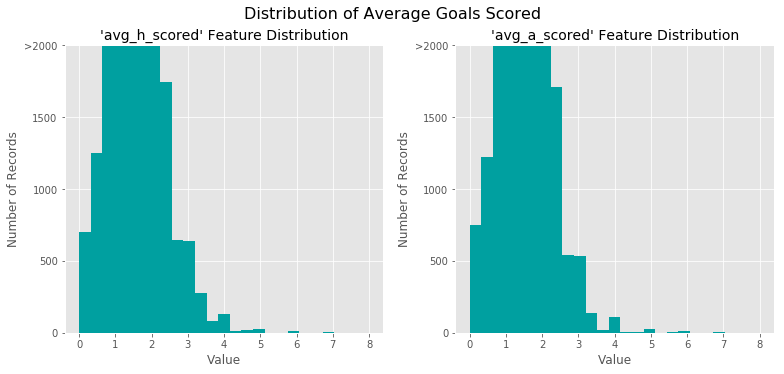

In [46]:
# Plotting the distribution of average goals scored by the home & away team.
# As shown there is a very small amount of outliers up near the 6 goals+ region
vs.distribution(clean_data, transformed = False)

**As the averages are built per season, if we remove the first 5 games of the season this should help to remove those top end outliers for average goals per game**

c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


div_name  hometeam_instance  awayteam_instance  \
81  Belgium Jupiler League                  6                  6   
83  Belgium Jupiler League                  6                  6   
84  Belgium Jupiler League                  6                  6   
85  Belgium Jupiler League                  6                  6   
86  Belgium Jupiler League                  6                  6   

    ft_total_goals  avg_h_scored  avg_a_conc  avg_a_scored  avg_h_conc  \
81             1.0           0.8         1.2           1.8         1.4   
83             3.0           2.4         1.2           1.6         1.8   
84             5.0           2.2         2.0           1.4         1.6   
85             1.0           1.4         1.2           1.0         1.2   
86             3.0           0.4         1.2           1.4         1.8   

    h_form_over25  h_form_under25  a_form_over25  a_form_under25  \
81            1.0             4.0            2.0             3.0   
83            4.0             1.0            3.0             2.0   
84            3.0             2.0            3.0             2.0   
85            2.0             3.0            2.0             3.0   
86            3.0             2.0            3.0             2.0   

    high_scoring_flag  row_count  
81                  0          1  
83                  1          1  
84                  1          1  
85                  0          1  
86                  1          1

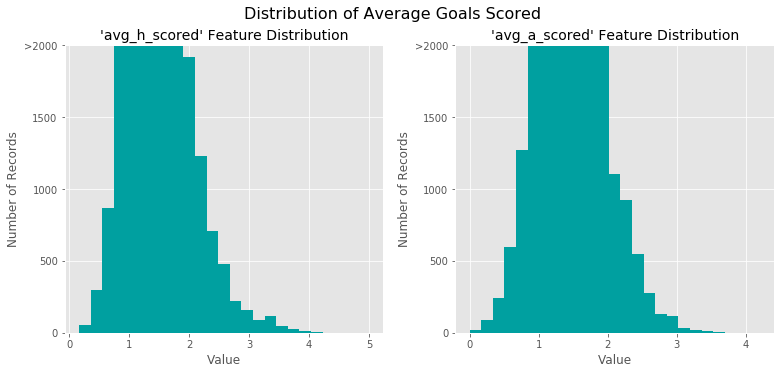

In [47]:
# Take out the first 5 games of every season to give the averages chance to build up to something more meaningful
lag_season_start = clean_data[(clean_data['hometeam_instance'] > 5) & (football_data['awayteam_instance'] > 5)]

vs.distribution(lag_season_start, transformed = False)

lag_season_start.head()

**The results above show that some of the more distant outliers have been removed, logically this will have had a similar affect to the average goals conceded columns as well.Seeing as football does not have a huge range in terms of the average number of goals scored I do not think transforming the data set will bring much difference to the average goals scored columns.**

**I hypothesis that the amount of games that end with 3+ goals changes per division, below will test that statement**

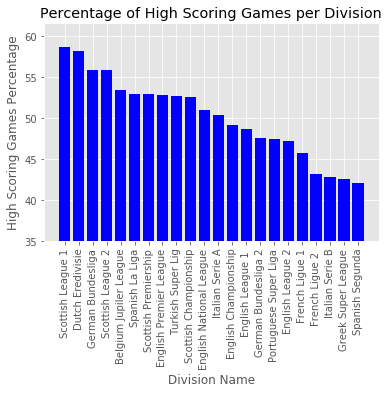

In [48]:
# Pivot the current data set to show division name & percentage of games that ended with 3+ goals
# Prep the data to pivot to work out 3+ percentage per league
division_data = clean_data[['div_name' , 'high_scoring_flag', 'row_count']]

# Pivot the data to group by league
division_table = pd.pivot_table(division_data,  values= ['high_scoring_flag' , 'row_count']
                                , index=['div_name'] , aggfunc= np.sum ).reset_index()

# Adding another colummn to the table, percentage of games ending with 3+ goals 
division_table = division_table.assign(high_scoring_percent = round(division_table.high_scoring_flag 
                                                                    / division_table.row_count * 100 , 1))

# Sorting the table ready for plotting
division_table = division_table.sort_values(by='high_scoring_percent', ascending=False)


# Plotting Graph of high scoring games percentage per division
plt.style.use('ggplot')

x_pos = arr.array('d', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 , 11 , 12 , 13, 14, 15, 16, 17, 18, 19, 20, 21])
#[i for i, _ in enumerate('div_name')]

plt.bar(division_table['div_name'], division_table['high_scoring_percent'], color='blue')
plt.xlabel("Division Name")
plt.ylabel("High Scoring Games Percentage")
plt.title("Percentage of High Scoring Games per Division")
plt.axis(ymin = 35)
plt.margins(tight = False)
plt.xticks(x_pos, division_table['div_name'], rotation = 'vertical')

plt.show()

**Next step is applying the benchmark poisson model to the dataset and scoring this model**

In [49]:
# Using the p.prob function, apply the poisson probability of a game ending with 3+ goals
lag_season_start['poisson_prob_3plus'] = lag_season_start[['avg_h_scored', 'avg_a_scored',
                                               'avg_h_conc', 'avg_a_conc']].apply(p.prob, axis=1)

lag_season_start['prediction_outcome'] = lag_season_start[['poisson_prob_3plus', 'ft_total_goals']].apply(ps.prediction_outcome, axis=1)

lag_season_start.head()



c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


div_name  hometeam_instance  awayteam_instance  \
81  Belgium Jupiler League                  6                  6   
83  Belgium Jupiler League                  6                  6   
84  Belgium Jupiler League                  6                  6   
85  Belgium Jupiler League                  6                  6   
86  Belgium Jupiler League                  6                  6   

    ft_total_goals  avg_h_scored  avg_a_conc  avg_a_scored  avg_h_conc  \
81             1.0           0.8         1.2           1.8         1.4   
83             3.0           2.4         1.2           1.6         1.8   
84             5.0           2.2         2.0           1.4         1.6   
85             1.0           1.4         1.2           1.0         1.2   
86             3.0           0.4         1.2           1.4         1.8   

    h_form_over25  h_form_under25  a_form_over25  a_form_under25  \
81            1.0             4.0            2.0             3.0   
83            4.0             1.0            3.0             2.0   
84            3.0             2.0            3.0             2.0   
85            2.0             3.0            2.0             3.0   
86            3.0             2.0            3.0             2.0   

    high_scoring_flag  row_count  poisson_prob_3plus prediction_outcome  
81                  0          1            0.481570                 TN  
83                  1          1            0.679153                 TP  
84                  1          1            0.697253                 TP  
85                  0          1            0.430291                 TN  
86                  1          1            0.430291                 FN

**Calculate the accuracy & the precision score of the benchmark model:**

In [50]:
# Calculate the accuracy & precision score of the benchmark poisson model
# True Positives
TP = len(lag_season_start[lag_season_start['prediction_outcome'] == 'TP'])

# True Negatives
TN = len(lag_season_start[lag_season_start['prediction_outcome'] == 'TN'])

# False Postives
FP = len(lag_season_start[lag_season_start['prediction_outcome'] == 'FP'])

# False Negatives
FN = len(lag_season_start[lag_season_start['prediction_outcome'] == 'FN'])


accuracy = round((TP + TN) / (TP + TN + FP + FN)*100,2)
precision = round(TP / (TP + FP)*100,2)

print(TP)
print(TN)
print(FP)
print(FN)
print("Poisson Model Accuracy: {}".format(accuracy))
print("Poisson Model Precision: {}".format(precision))

6852
8617
5912
7242
Poisson Model Accuracy: 54.04
Poisson Model Precision: 53.68


# Data Preperation

**Continue prepping the data for the machine learning algorithms to train on**

In [51]:
# Start prepping the data for inputting into the algorithms
# Remove all columns that arent the target variable & predictor variables
lag_season_start = lag_season_start.drop(['ft_total_goals' , 'prediction_outcome' 
                                         , 'poisson_prob_3plus' , 'row_count'], axis=1) 
lag_season_start.head()


div_name  hometeam_instance  awayteam_instance  \
81  Belgium Jupiler League                  6                  6   
83  Belgium Jupiler League                  6                  6   
84  Belgium Jupiler League                  6                  6   
85  Belgium Jupiler League                  6                  6   
86  Belgium Jupiler League                  6                  6   

    avg_h_scored  avg_a_conc  avg_a_scored  avg_h_conc  h_form_over25  \
81           0.8         1.2           1.8         1.4            1.0   
83           2.4         1.2           1.6         1.8            4.0   
84           2.2         2.0           1.4         1.6            3.0   
85           1.4         1.2           1.0         1.2            2.0   
86           0.4         1.2           1.4         1.8            3.0   

    h_form_under25  a_form_over25  a_form_under25  high_scoring_flag  
81             4.0            2.0             3.0                  0  
83             1.0            3.0             2.0                  1  
84             2.0            3.0             2.0                  1  
85             3.0            2.0             3.0                  0  
86             2.0            3.0             2.0                  1

**Now to start normalising , one hot encoding & split / shuffle the data for learning. Also need to define the target label**

In [38]:
# Re-define the data set variable
football_data = lag_season_start

# Target variable identified
high_scoring_flag = football_data['high_scoring_flag']
football_data = football_data.drop('high_scoring_flag', axis = 1)

# Normalising the numeric variables 
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['hometeam_instance', 'awayteam_instance', 'avg_h_scored'
             ,'avg_a_scored', 'avg_h_conc', 'avg_a_conc', 'h_form_over25' 
             , 'h_form_under25' , 'a_form_over25' , 'a_form_under25']

transformed_data = pd.DataFrame(data = football_data)
transformed_data[numerical] = scaler.fit_transform(football_data[numerical])

transformed_data.head()

c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


div_name  hometeam_instance  awayteam_instance  \
81  Belgium Jupiler League                0.0                0.0   
83  Belgium Jupiler League                0.0                0.0   
84  Belgium Jupiler League                0.0                0.0   
85  Belgium Jupiler League                0.0                0.0   
86  Belgium Jupiler League                0.0                0.0   

    avg_h_scored  avg_a_conc  avg_a_scored  avg_h_conc  h_form_over25  \
81      0.131028    0.285714      0.428571    0.381815            0.2   
83      0.462065    0.285714      0.380952    0.490905            0.8   
84      0.420686    0.476190      0.333333    0.436360            0.6   
85      0.255167    0.285714      0.238095    0.327270            0.4   
86      0.048269    0.285714      0.333333    0.490905            0.6   

    h_form_under25  a_form_over25  a_form_under25  
81             0.8            0.4             0.6  
83             0.2            0.6             0.4  
84             0.4            0.6             0.4  
85             0.6            0.4             0.6  
86             0.4            0.6             0.4

In [15]:
# Show an example of a record with scaling applied
#display(transformed_data.head(n = 5))

# One-hot encode the categoric variable 
final_transform = pd.get_dummies(transformed_data)

final_transform.head()

# Check number of features
encoded = list(final_transform.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

32 total features after one-hot encoding.


In [16]:
# Split the data set into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(final_transform, 
                                                    high_scoring_flag, 
                                                    test_size = 0.2, 
                                                    random_state = 95)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 22898 samples.
Testing set has 5725 samples.


# Implementing the Algorithms

**Implement and then tune parameters to increase precision score**

In [17]:
# Random Forest Initial Implementation & Tuning
# Initialize the classifier
clf = RandomForestClassifier(random_state = 95)

clf.get_params().keys()

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = { 'n_estimators' : [25 , 50, 75 , 100]  , 'criterion' : [ 'gini' , 'entropy'] 
              , 'max_depth' : [ 16 , 32 , 64 , 128 ] , 'max_features' : [ 'sqrt' , 'log2']
              , 'max_leaf_nodes' : [ 16 , 32 , 64 , 128 ]}

#  Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.4 )

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV( clf , parameters , scoring = scorer )

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train , y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.4)))
print("Precision on the testing data: {:.4f}".format(precision_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.4)))
print("Final Precision on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))

c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.5128
F-score on testing data: 0.4743
Precision on the testing data: 0.4886

Optimized Model
------
Final accuracy score on the testing data: 0.5331
Final F-score on the testing data: 0.5044
Final Precision on the testing data: 0.5134


In [18]:
print(best_clf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'max_leaf_nodes': 16, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': None, 'oob_score': False, 'random_state': 95, 'verbose': 0, 'warm_start': False}


In [19]:
# Random Forest Tuning
# Initialize the classifier
clf = SVC( random_state = 95 )

clf.get_params().keys()

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = { 'C' : [  0.1, 1, 10, 1000 ]  , 'kernel' : [ 'rbf', 'sigmoid' ] 
               }

#  Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.4 )

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV( clf , parameters , scoring = scorer )

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train , y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.4)))
print("Precision on the testing data: {:.4f}".format(precision_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.4)))
print("Final Precision on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))



c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning

c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid

Unoptimized model
------
Accuracy score on testing data: 0.5308
F-score on testing data: 0.5057
Precision on the testing data: 0.5101

Optimized Model
------
Final accuracy score on the testing data: 0.5385
Final F-score on the testing data: 0.5130
Final Precision on the testing data: 0.5190


# Testing Robustness & Final Visuals

**First, re - create the same data as before but this time only lookign at the top 5 divisions as defined in the report
**

In [63]:
# Re-define the data set variable
top_5_data = lag_season_start[(lag_season_start['div_name'] == 'English Premier League') 
                                              | (lag_season_start['div_name'] == 'Spanish La Liga')
                                              | (lag_season_start['div_name'] == 'German Bundesliga')
                                              | (lag_season_start['div_name'] == 'Italian Serie A')
                                              | (lag_season_start['div_name'] == 'French Ligue 1')]

top_5_data.head()

div_name  hometeam_instance  awayteam_instance  \
11120  English Premier League                  6                  6   
11121  English Premier League                  6                  7   
11122  English Premier League                  6                  6   
11123  English Premier League                  6                  7   
11124  English Premier League                  6                  7   

       avg_h_scored  avg_a_conc  avg_a_scored  avg_h_conc  h_form_over25  \
11120           2.2      2.0000        1.6000         1.2            3.0   
11121           1.0      2.3333        1.3333         1.2            1.0   
11122           0.6      1.0000        3.6000         1.8            2.0   
11123           1.4      1.8333        1.3333         1.8            3.0   
11124           2.4      0.6667        1.3333         0.8            4.0   

       h_form_under25  a_form_over25  a_form_under25  high_scoring_flag  
11120             2.0            5.0             0.0                  1  
11121             4.0            5.0             0.0                  0  
11122             3.0            4.0             1.0                  1  
11123             2.0            3.0             2.0                  1  
11124             1.0            3.0             2.0                  1

In [64]:
# Target variable identified
top_5_high_scoring_flag = top_5_data['high_scoring_flag']

In [65]:
top_5_data_prep = top_5_data.drop('high_scoring_flag', axis = 1)

# Normalising the numeric variables 
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['hometeam_instance', 'awayteam_instance', 'avg_h_scored'
             ,'avg_a_scored', 'avg_h_conc', 'avg_a_conc', 'h_form_over25' 
             , 'h_form_under25' , 'a_form_over25' , 'a_form_under25']

top_5_transformed_data = pd.DataFrame(data = top_5_data_prep)
top_5_transformed_data[numerical] = scaler.fit_transform(top_5_data_prep[numerical])

top_5_transformed_data['div_name'].unique()

c:\users\burroughsp\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array(['English Premier League', 'French Ligue 1', 'German Bundesliga',
       'Italian Serie A', 'Spanish La Liga'], dtype=object)

In [69]:
# One-hot encode & split data 
top_five_transform = pd.get_dummies(top_5_transformed_data)


# Check number of features
top_five_encoded = list(top_five_transform.columns)
print("{} total features after one-hot encoding.".format(len(top_five_encoded)))

# Split Data
# Split the data set into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(top_five_transform, 
                                                    top_5_high_scoring_flag, 
                                                    test_size = 0.2, 
                                                    random_state = 95)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

15 total features after one-hot encoding.
Training set has 5262 samples.
Testing set has 1316 samples.


In [70]:
# Train & Test model 
# Model hyperparmeters initialised 
robust_forest = RandomForestClassifier(n_estimators = 75, criterion = 'gini',
                                       max_depth = 16, max_features = 'sqrt', 
                                       max_leaf_nodes = 16, random_state = 95)

# Fitting the model 
robust_forest = (robust_forest.fit(X_train, y_train))

# Predict & Score model
top_5_predictions = robust_forest.predict(X_test)

# Scores
print("Top 5 Robust Test\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, top_5_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, top_5_predictions, beta = 0.4)))
print("Precision on the testing data: {:.4f}".format(precision_score(y_test, top_5_predictions)))




Top 5 Robust Test
------
Accuracy score on testing data: 0.5099
F-score on testing data: 0.5320
Precision on the testing data: 0.5223


## Looking at feature importance 

Text(0.5,0,'Relative Importance')

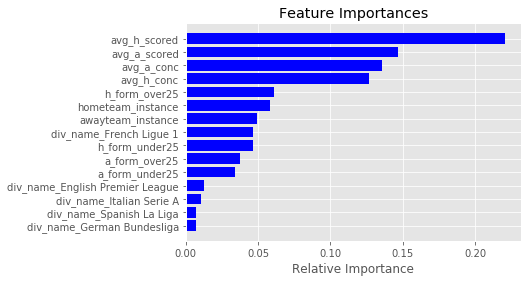

In [83]:
# Calculating & Plotting Feature importance
importances = robust_forest.feature_importances_
indices = np.argsort(importances)

features = top_five_transform.columns[0:15]



plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

## Code taken from http://www.agcross.com/2015/02/random-forests-scikit-learn/ 